# EDAを通して特徴量を探る
まず仮説を立て、それを確認するためのコードを検討    
目的：スペインマレーシアの電力価格の予測
■前提  
* まず、与えられた都市の地形を出す→地形コード？→DONE
* price_actualの時系列データを出し傾向をつかみたい→DONE
* 各都市の気温、最高・最低気温の時系列変化を見る→DONE
* price_actualと各発電方式の相関を見る→DONE
* price_actualの価格の外れ値はないかを見る→DONE

■仮説  
* 価格は需要と供給に基づくという点から何かしらの発電量と相関関係があるのではないか？→発電法によって価格弾力性は異なると考えられる
* 朝・昼・夜などの時間帯によって価格変動があるのではないか？
* 春夏秋冬、季節性による価格変動があるのではないか？
* スペイン特有の大イベントなどがあると仮定すると、そのあたりの価格は常時より高くなるのではないか？
* 風力発電は、風速の強さの影響があるのではないか？
* 降雨量が高い時、
  
■特徴量作成のためのメモ
* 急激な価格変化があった前後のLagをとることで精度があがるのではないか？
* 再エネ比率（再エネ発電 / 総発電量）が有効な特徴量として働く可能性がある？


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 目的：スペインの電力価格を予測
# 目的変数：スペインの電力価格(actual_price)
# 評価指標：RME

import numpy as np
import pandas as pd
import os
import pickle
import gc
# 分布確認
!pip install ydata-profiling
from ydata_profiling import ProfileReport
# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder,OneHotEncoder
# モデリング
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
# 日本語表記
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline
# パラメータ最適化
!pip install optuna
import optuna
# 地図表示用
import folium

In [4]:
file_path = "/content/drive/MyDrive/Colab Notebooks/signate/smbc/"

df_train = pd.read_csv(file_path + "train.csv")
df_test = pd.read_csv(file_path + "test.csv")
df_sample = pd.read_csv(file_path + "sample_submit.csv",header=None)

In [ ]:
print(df_train.shape)
display(df_train.head())
display(df_train.tail())
display(df_test.head())
display(df_test.tail())

(26280, 92)


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual
0,2015-01-02 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,64.02
1,2015-01-02 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,58.46
2,2015-01-02 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.70
3,2015-01-02 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.91
4,2015-01-02 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,53.07


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual
26275,2017-12-31 19:00:00+01:00,286.0,0.0,3960.0,1039.0,208.0,0.0,1140.0,4593.0,7094.0,...,230,0.0,0.0,0.0,40,802,clouds,scattered clouds,03n,39.90
26276,2017-12-31 20:00:00+01:00,282.0,0.0,3918.0,1053.0,220.0,0.0,1160.0,4582.0,7098.0,...,260,0.0,0.0,0.0,75,803,clouds,broken clouds,04n,39.54
26277,2017-12-31 21:00:00+01:00,284.0,0.0,3867.0,1048.0,228.0,0.0,1158.0,4368.0,7100.0,...,270,0.0,0.0,0.0,40,802,clouds,scattered clouds,03n,32.90
26278,2017-12-31 22:00:00+01:00,280.0,0.0,4033.0,928.0,225.0,0.0,1115.0,4027.0,7101.0,...,320,0.0,0.0,0.0,40,802,clouds,scattered clouds,03n,23.85
26279,2017-12-31 23:00:00+01:00,290.0,0.0,4252.0,873.0,193.0,30.0,1088.0,2956.0,7102.0,...,310,0.0,0.0,0.0,20,801,clouds,few clouds,02n,23.95


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon
0,2018-01-01 00:00:00+01:00,279.0,0.0,3927.0,895.0,189.0,230.0,1069.0,1893.0,7104.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2018-01-01 01:00:00+01:00,282.0,0.0,3948.0,878.0,177.0,1269.0,1058.0,1024.0,7101.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2018-01-01 02:00:00+01:00,283.0,0.0,3791.0,890.0,175.0,2197.0,1052.0,888.0,7100.0,...,1,0,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2018-01-01 03:00:00+01:00,280.0,0.0,3671.0,881.0,175.0,2965.0,1032.0,645.0,7101.0,...,1,40,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2018-01-01 04:00:00+01:00,286.0,0.0,3460.0,861.0,173.0,2705.0,1001.0,661.0,7101.0,...,1,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon
8755,2018-12-31 19:00:00+01:00,266.0,0.0,5730.0,1510.0,228.0,1.0,1158.0,3422.0,6071.0,...,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
8756,2018-12-31 20:00:00+01:00,275.0,0.0,5683.0,1556.0,221.0,1.0,1155.0,3501.0,6070.0,...,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
8757,2018-12-31 21:00:00+01:00,275.0,0.0,5859.0,1616.0,216.0,1.0,1167.0,4248.0,6070.0,...,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
8758,2018-12-31 22:00:00+01:00,283.0,0.0,5660.0,1610.0,215.0,1.0,1160.0,3757.0,6071.0,...,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n
8759,2018-12-31 23:00:00+01:00,284.0,0.0,5603.0,1622.0,225.0,1.0,1118.0,2993.0,6072.0,...,3,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [ ]:
# 時刻をdatetimeに変換
df_train["time"] = pd.to_datetime(df_train["time"],utc=True)

# ケルビンを摂氏に変換  - 273.15
cities = ["valencia","madrid","bilbao","barcelona","seville"]
for city in cities:
  df_train[f"{city}_temp"] = df_train[f"{city}_temp"] - 273.15
  df_train[f"{city}_temp_min"] = df_train[f"{city}_temp_min"] - 273.15
  df_train[f"{city}_temp_max"] = df_train[f"{city}_temp_max"] - 273.15

In [ ]:
categorical_cols = [col for col in df_train.select_dtypes(include=["object","category"]).columns]
numerical_cols = [col for col in df_train.select_dtypes(include=["int64","float64"]).columns]
print("*"*20,"実行結果確認","*"*20,)
print(f"カテゴリ{categorical_cols}")
print(f"数値{numerical_cols}")

******************** 実行結果確認 ********************
カテゴリ['valencia_weather_main', 'valencia_weather_description', 'valencia_weather_icon', 'madrid_weather_main', 'madrid_weather_description', 'madrid_weather_icon', 'bilbao_weather_main', 'bilbao_weather_description', 'bilbao_weather_icon', 'barcelona_weather_main', 'barcelona_weather_description', 'barcelona_weather_icon', 'seville_weather_main', 'seville_weather_description', 'seville_weather_icon']
数値['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual', 'valencia_temp', 'valencia_temp_min', 'valencia_temp_max', 'valencia_pressure', 'valencia_humidity', 'valencia_wi

/tmp/ipython-input-7-3253200021.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")


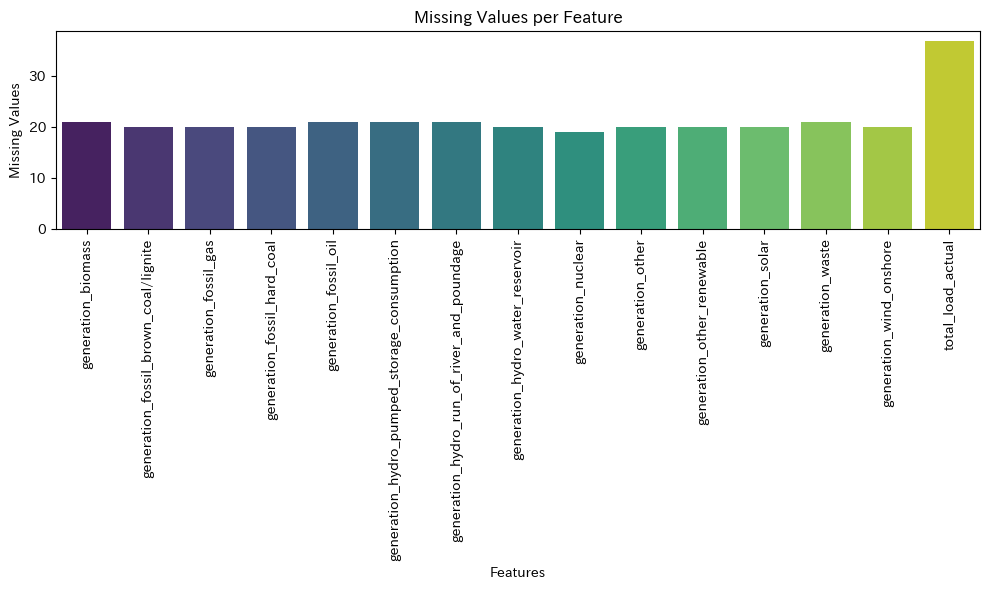

In [ ]:
def missing_check(df):
  missing_values = df.isnull().sum()
  missing_values = missing_values[missing_values > 0]

  if not missing_values.empty:
      plt.figure(figsize=(10, 6))
      sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")
      plt.xticks(rotation=90)
      plt.xlabel("Features")
      plt.ylabel("Missing Values")
      plt.title("Missing Values per Feature")
      plt.tight_layout()
      plt.show()
  else:
      print("✅ No missing values found in the dataset.")

missing_check(df_train)

actualがやや多めだが、外れ値は多くない  
→そんなに欠損は気にする必要なさそう

In [ ]:
# 特徴量として与えられている地域の可視化

# 都市名と緯度・経度の辞書
cities = {
    "valencia": (39.4699, -0.3763),
    "madrid": (40.4168, -3.7038),
    "bilbao": (43.2630, -2.9350),
    "barcelona": (41.3851, 2.1734),
    "seville": (37.3891, -5.9845)
}

# スペインの中心あたりにフォーカスした地図を作成
spain_map = folium.Map(location=[40.0, -3.5], zoom_start=6)

# 各都市にマーカーを追加
for city, coords in cities.items():
    folium.Marker(location=coords, popup=city).add_to(spain_map)

# 地図を表示（Jupyter Notebook などで）
spain_map

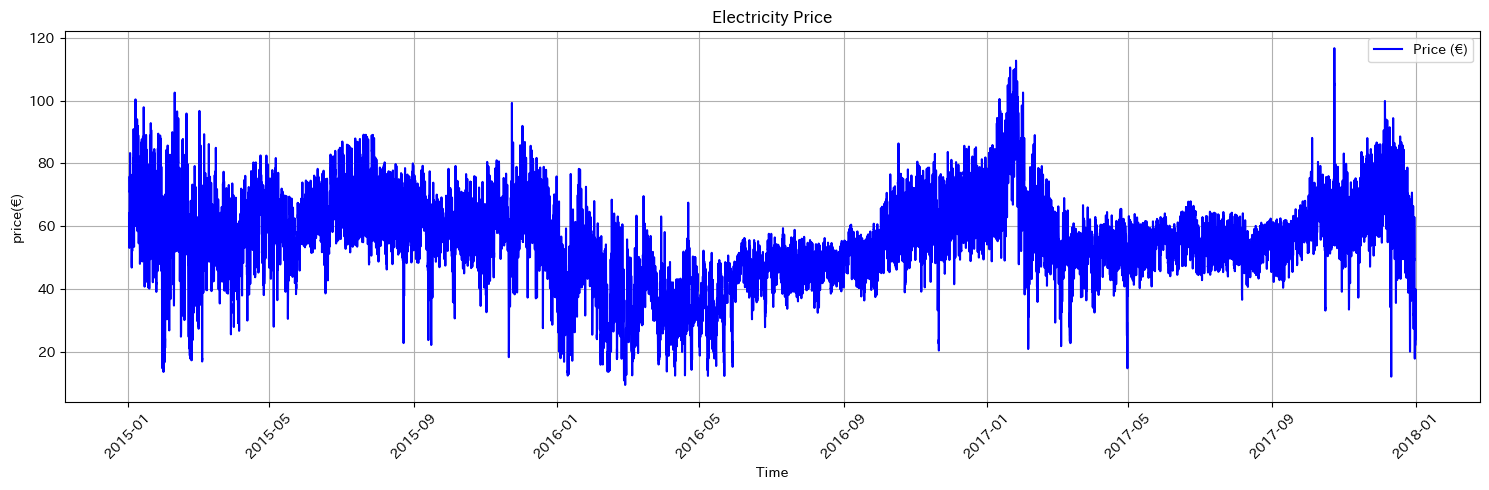

In [ ]:
# 時系列データの確認

# グラフの描画
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_train,x="time", y="price_actual", label="Price (€)", color="blue")

plt.xlabel("Time")
plt.ylabel("price(€)")
plt.title("Electricity Price")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

季節的な傾向がややありそう（冬に価格高騰）

<Figure size 2000x500 with 0 Axes>

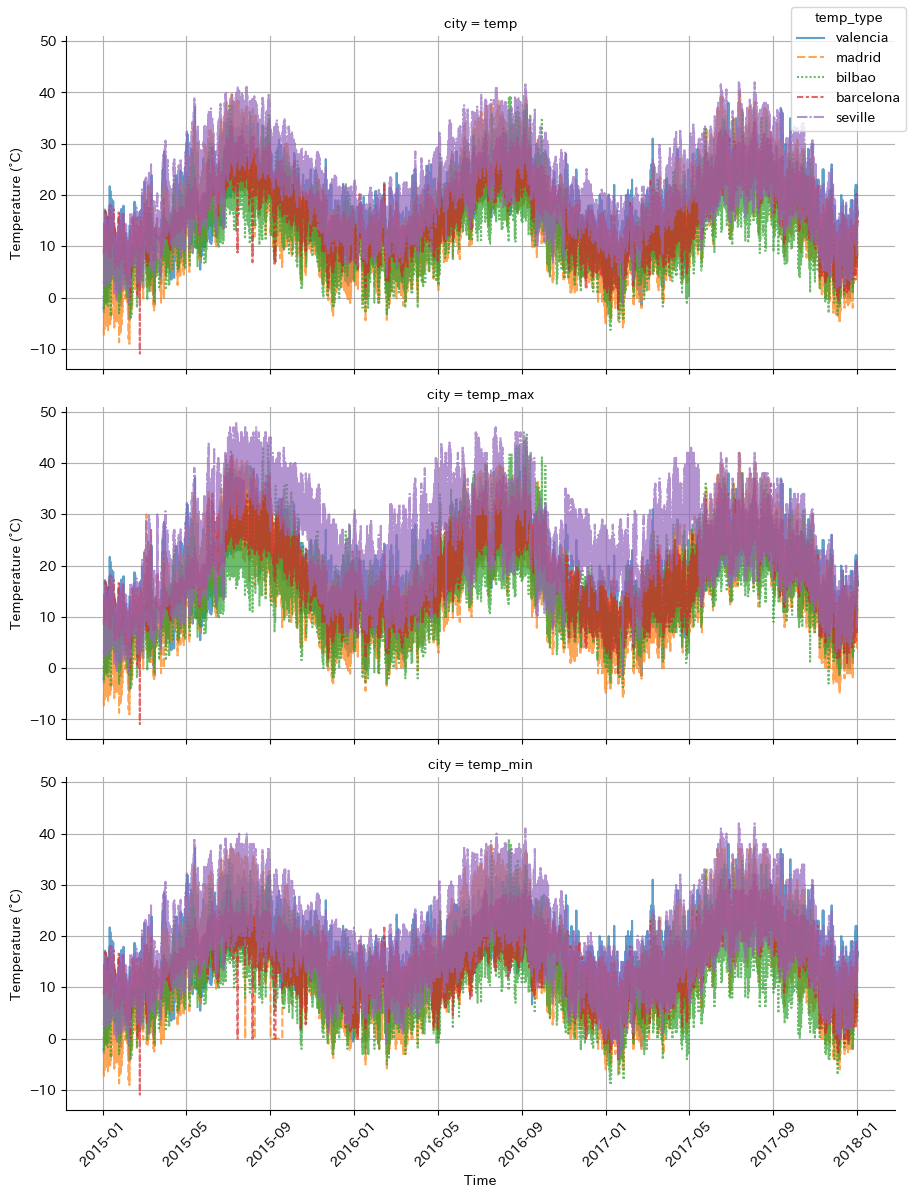

In [ ]:
# 使いたい列だけ抽出
temp_cols = [f"{c}_temp" for c in cities] + [f"{c}_temp_max" for c in cities] + [f"{c}_temp_min" for c in cities]
df_temp = df_train[["time"] + temp_cols]

# wide → long
df_melt = df_temp.melt(id_vars="time", var_name="city_type", value_name="temp")

# city と temp_type に分解（例: "temp_max_barcelona" → "barcelona", "temp_max"）
df_melt["city"] = df_melt["city_type"].apply(lambda x: "_".join(x.split("_")[1:]))
df_melt["temp_type"] = df_melt["city_type"].apply(lambda x: x.split("_")[0])

# FacetGridで都市ごとに分ける
plt.figure(figsize=(20, 5))
g = sns.relplot(
    data=df_melt,
    x="time", y="temp",
    row="city",           # 都市ごとにグラフを分割
    hue="temp_type",      # 都市ごとに色を変える
    style="temp_type",    # 平均・最高・最低で線種を変える
    kind="line",
    alpha=0.7,
    height=4, aspect=2,
    facet_kws={"sharey": True}  # Y軸を共通にして比較しやすく
)

g.set_titles(col_template="{col_name}")  # グラフタイトルに都市名だけ
g.set_axis_labels("Time", "Temperature (°C)")
g._legend.set_loc("upper right") # 凡例を右上に表示
g._legend.set_frame_on(True) # 凡例に枠線を追加

for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.show()

各都市の気温傾向はおおむね同じ。  
vallensia＆sevilleがやや全体的に高い傾向がある。


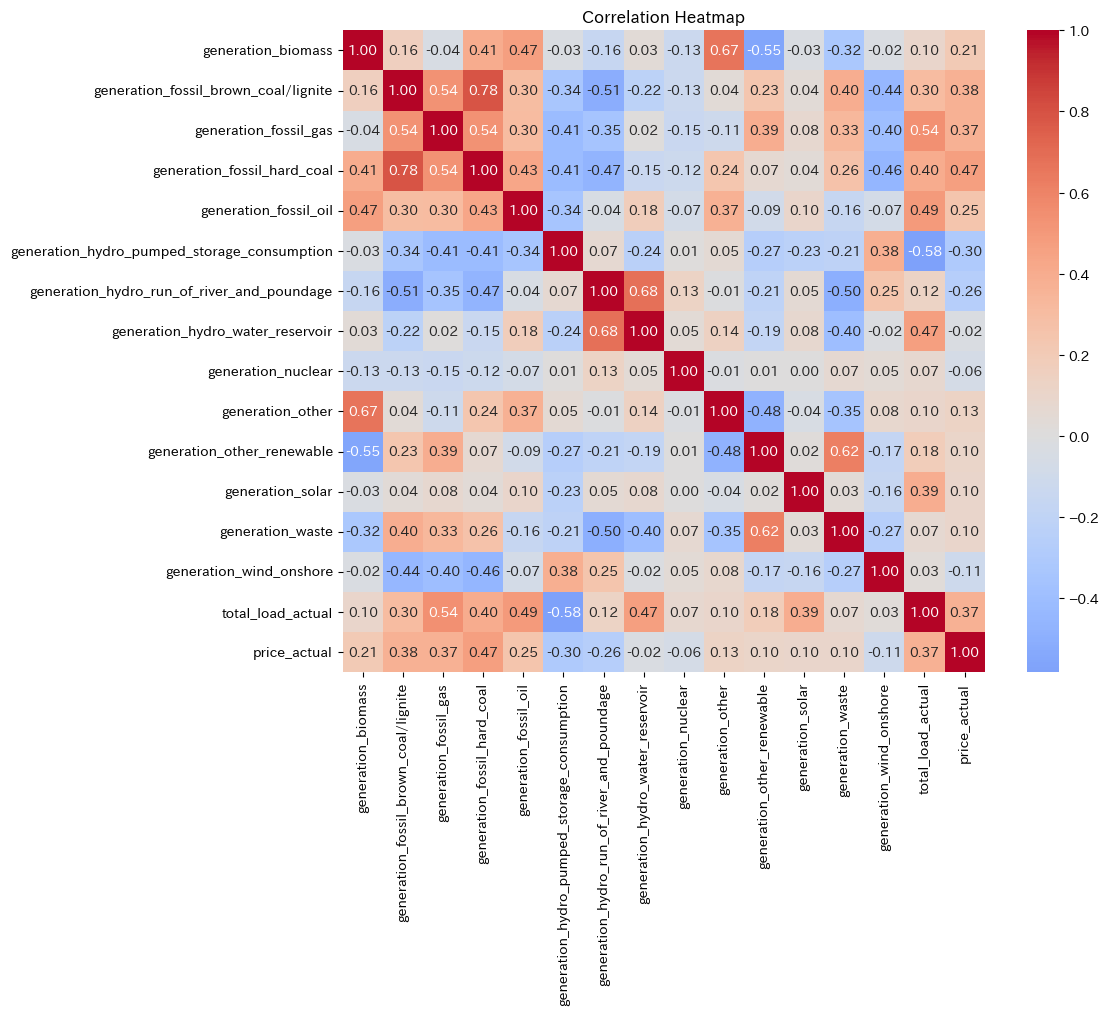

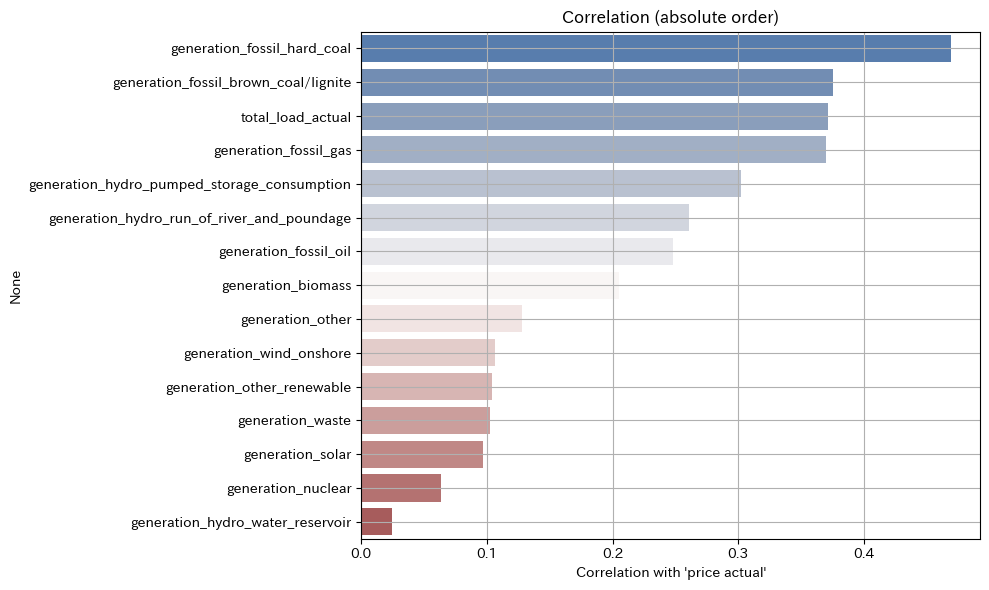

In [ ]:
# generation×目的変数との相関を見る
corr_list = ['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas',
          'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption',
          'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear',
          'generation_other', 'generation_other_renewable',
          'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual','price_actual']
corr_check = df_train[corr_list].corr()

# ヒートマップ描画
plt.figure(figsize=(12, 10))
sns.heatmap(corr_check, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# 絶対値の大きい順に横棒グラフで描画
target = "price_actual"
corr_target = corr_check[target].drop(target)
corr_sorted = corr_target.reindex(corr_target.abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))

sns.barplot(
    x=corr_sorted.abs().values,
    y=corr_sorted.index,
    hue=corr_sorted.index,
    orient="h",
    palette="vlag",
    legend=False,
    )

plt.xlabel("Correlation with 'price actual'")
plt.title("Correlation (absolute order)")

plt.grid(True)
plt.tight_layout()
plt.show()


"generation_fossil_hard_coal","generation_fossil_brown_coal/lignite","total_load_actual","generation_fossil_gas"あたりの相関が比較的高い(0.35以上)  
→火力発電の量と価格に正の相関がみられる

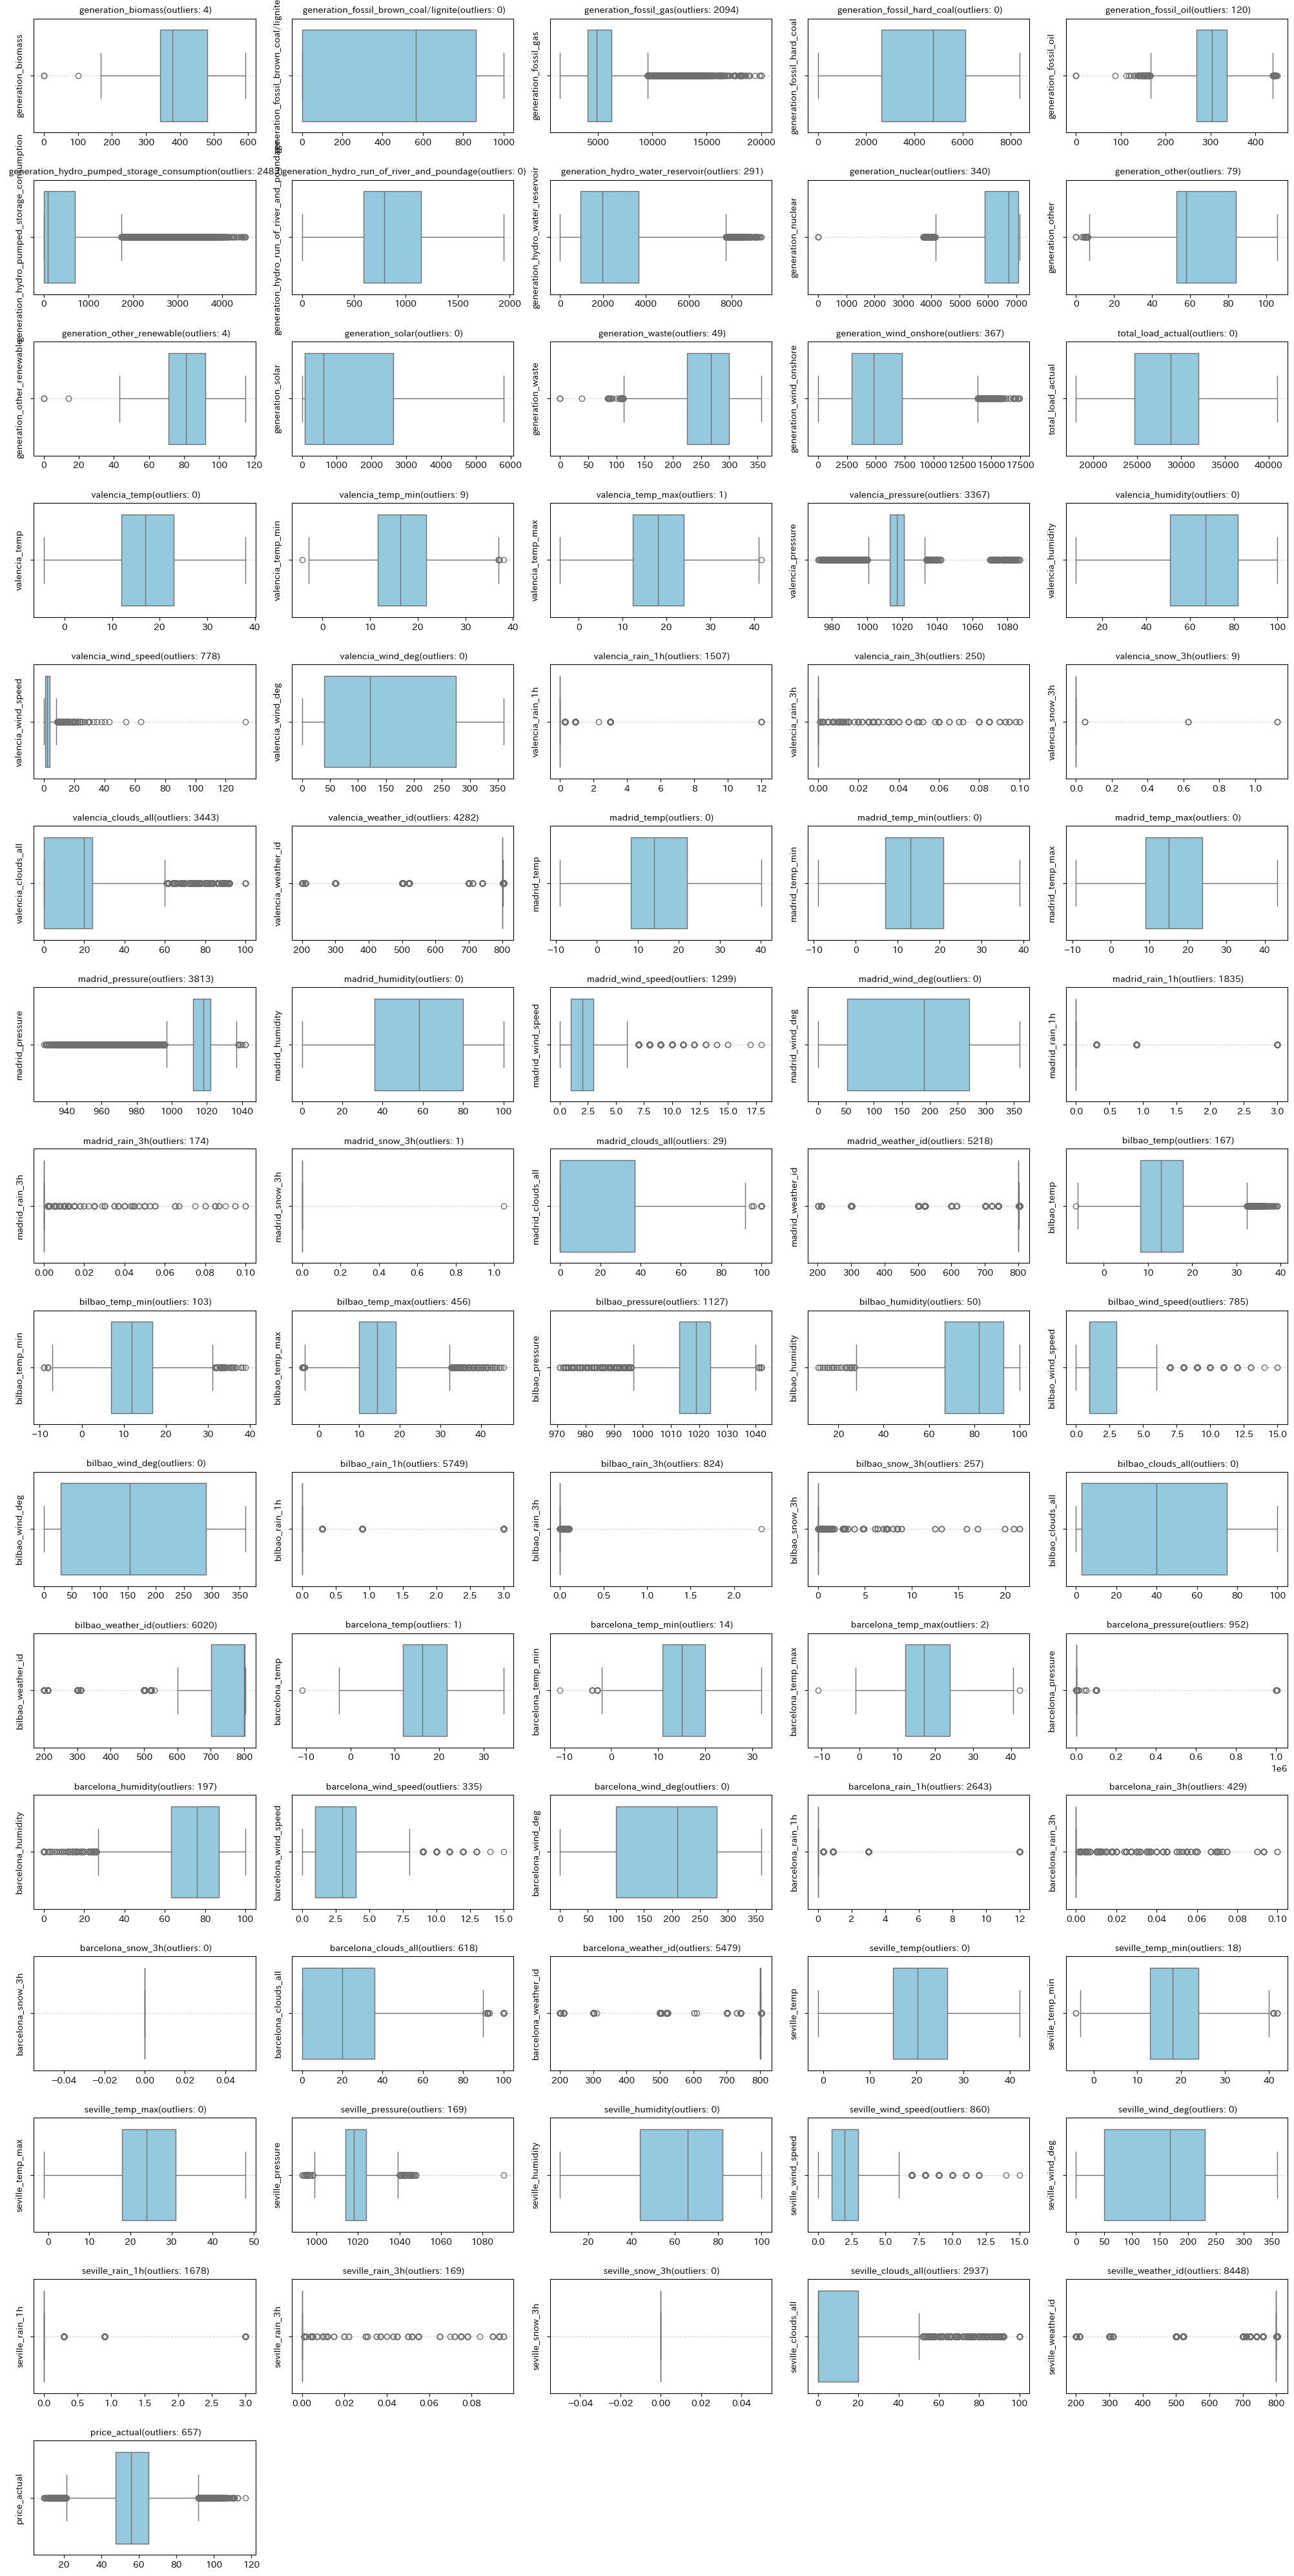

In [ ]:
# numericalデータ外れ値の確認

n_cols = 5  # 1行あたりの列数
n_rows = -(-len(numerical_cols) // n_cols)  # 行数（切り上げ）
plt.figure(figsize=(n_cols * 4, n_rows * 2.5))

for i,col in enumerate(numerical_cols):
  # IQRによる外れ値検出
  q1 = df_train[col].quantile(0.25)
  q3 = df_train[col].quantile(0.75)
  iqr = q3 - q1
  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr
  outlier_count = ((df_train[col] < lower) | (df_train[col] > upper)).sum()

  plt.subplot(n_rows, n_cols, i + 1)
  sns.boxplot(data=df_train,x=df_train[col],color="skyblue")
  plt.title(f" {col}(outliers: {outlier_count})",fontsize=10)
  plt.xlabel("")
  plt.ylabel(col, fontsize=10)
  plt.grid(axis='y', linestyle='--', alpha=0.5)
  plt.tight_layout()

plt.show()

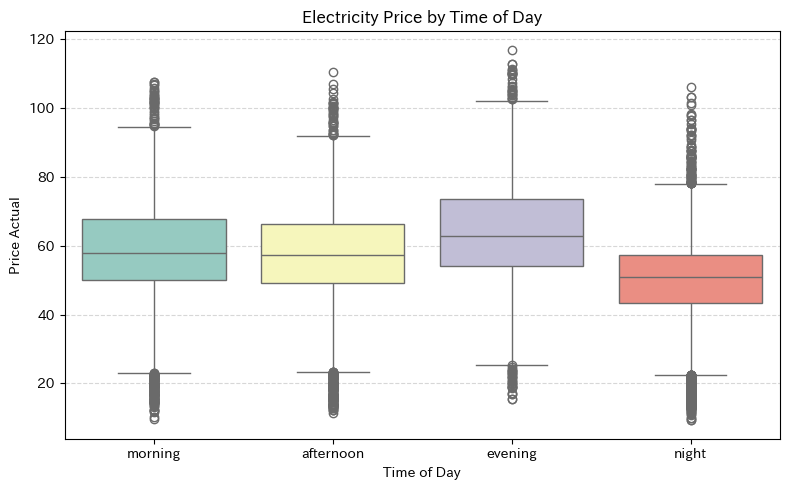

In [13]:
# 時間帯による価格への影響を可視化

df_train["hour"] = df_train["time"].dt.hour

# 時間帯カテゴリ列を作成（morning:1,afternoon:2,evening:3,night:4）
def get_time_of_day(hour):
    if 5 <= hour < 11:
        return 1
    elif 11 <= hour < 17:
        return 2
    elif 17 <= hour < 21:
        return 3
    else:
        return 4

df_train["time_of_day"] = df_train["hour"].apply(get_time_of_day)

# 時間帯ごとの価格変動を可視化
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_train,
    x="time_of_day",
    y="price_actual",
    hue="time_of_day",
    palette="Set3",
    legend=False
)
plt.title("Electricity Price by Time of Day")
plt.xlabel("Time of Day")
plt.xticks(ticks=range(4), labels=["morning", "afternoon", "evening", "night"])
plt.ylabel("Price Actual")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

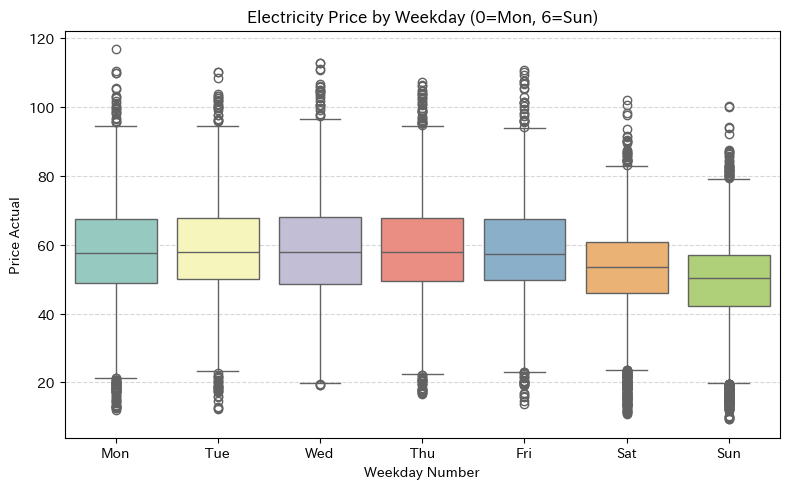

In [ ]:
# 曜日による影響ってあるのかを確認
# 曜日を数値（0=月曜, 6=日曜）で追加
df_train["weekday"] = df_train["time"].dt.weekday

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_train,
    x="weekday",
    y="price_actual",
    hue="weekday",
    palette="Set3",
    legend=False
    )
plt.title("Electricity Price by Weekday (0=Mon, 6=Sun)")
plt.xlabel("Weekday Number")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.ylabel("Price Actual")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


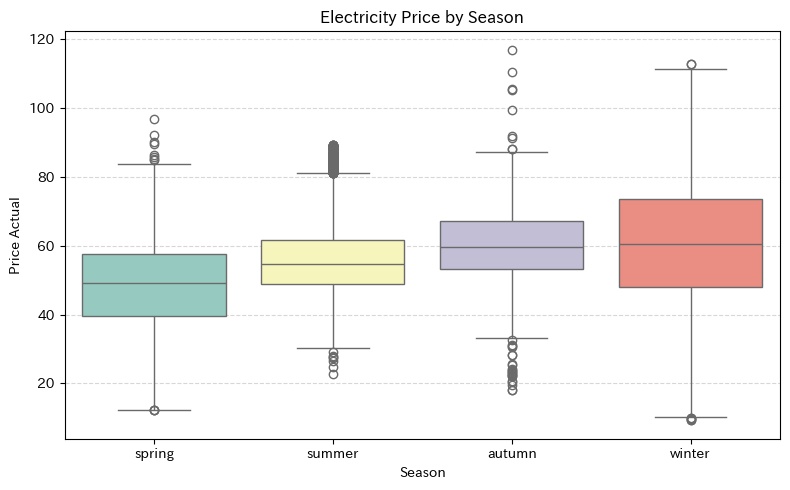

In [14]:
# 季節性による価格変動の可視化
def get_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

# 月を取得 → 季節に変換
df_train["month"] = df_train["time"].dt.month
df_train["season"] = df_train["month"].apply(get_season)
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_train,
    x="season",
    y="price_actual",
    hue="season",
    palette="Set3",
    legend=False
    )
plt.title("Electricity Price by Season")
plt.xlabel("Season")
plt.xticks(ticks=range(4), labels=["spring", "summer", "autumn", "winter"])
plt.ylabel("Price Actual")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

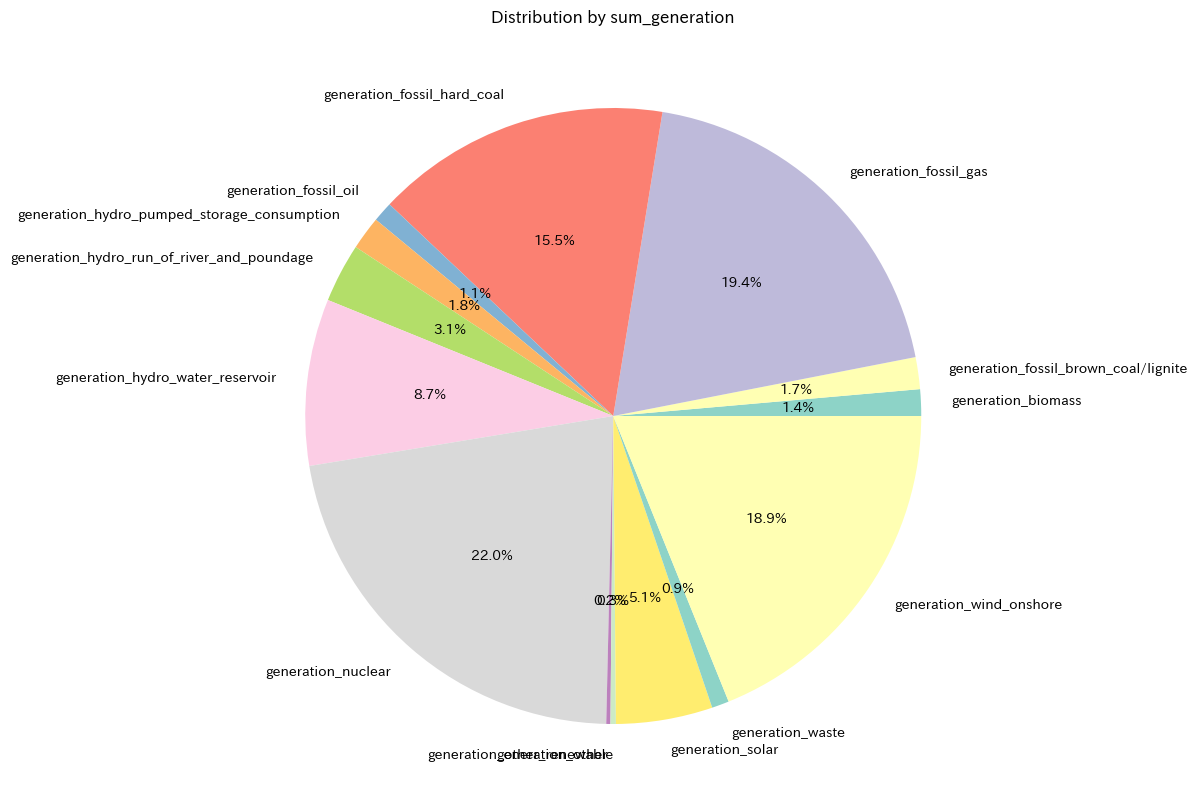

In [ ]:
# 発電量の割合を見てみる（forum参照）

generation_columns = [col for col in df_train.columns if 'generation' in col]
sum_generation = df_train[generation_columns].sum()

plt.figure(figsize=(10, 10))
plt.pie(sum_generation, labels=sum_generation.index, autopct='%1.1f%%', colors=plt.cm.Set3.colors)
plt.title("Distribution by sum_generation")
plt.show()

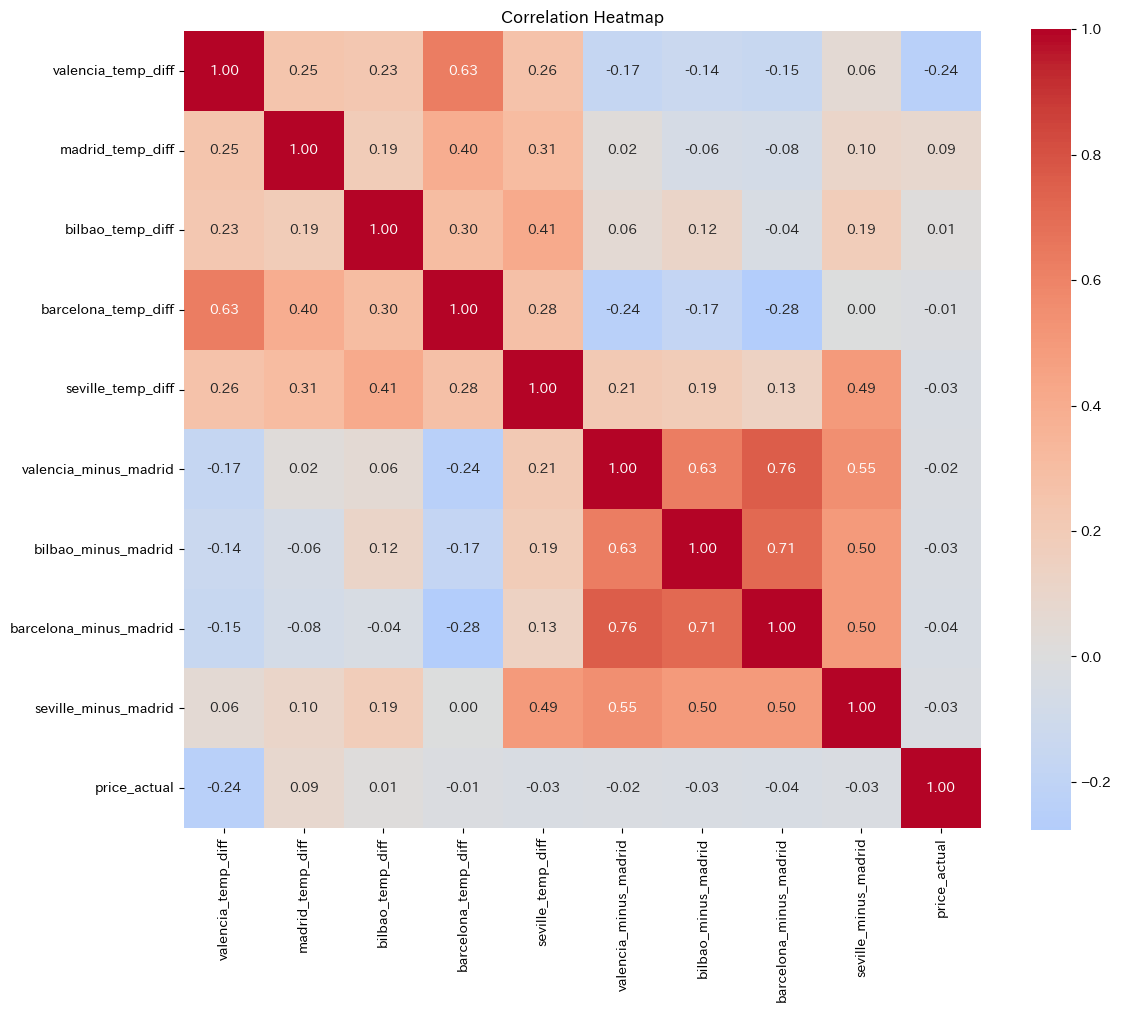

In [7]:

# 都市名のリスト
cities =["valencia","madrid","bilbao","barcelona","seville"]

# 各地域のMax＆Minの気温差
for city in cities:
  df_train[f"{city}_temp_diff"] = df_train[f"{city}_temp_max"] - df_train[f"{city}_temp_min"]

# 各都市間の気温差
base = "madrid"
for city in cities:
  if city == base:
    continue
  df_train[f"{city}_minus_{base}"] = df_train[f"{city}_temp"] - df_train[f"{base}_temp"]


# 相関を出したいカラム
temp_cols = [c for c in df_train.columns if c.endswith("_diff") or "_minus" in c]

temp_diff_corr = (df_train[temp_cols+["price_actual"]]).corr()

# ヒートマップ描画
plt.figure(figsize=(12, 10))
sns.heatmap(temp_diff_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


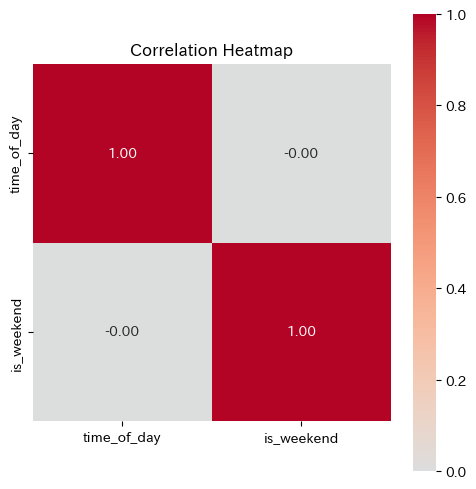

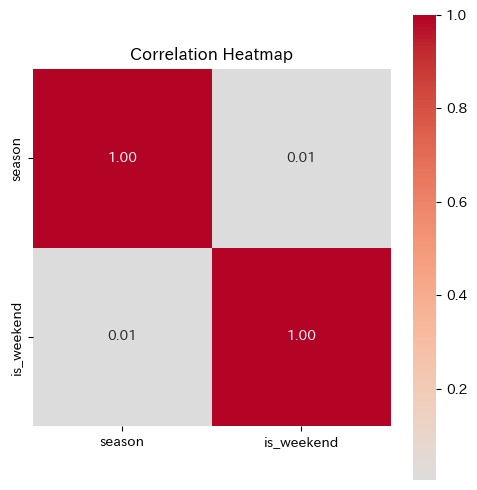

In [17]:
# time of dayとisweekend、seasonとisweekendの相関を見る
def is_week_end(weekday):
    if weekday in [0,1,2,3,4]:
      return 0
    elif weekday in [5,6]:
      return 1
    else:
      return 2

# 時刻をdatetimeに変換
df_train["time"] = pd.to_datetime(df_train["time"],utc=True)
df_test["time"] = pd.to_datetime(df_test["time"],utc=True)

df_train["weekday"] = df_train["time"].dt.weekday
df_train["is_weekend"] = df_train["weekday"].apply(is_week_end)

# 相関を見る
plt.figure(figsize=(5, 5))
sns.heatmap(
    df_train[["time_of_day","is_weekend"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
sns.heatmap(
    df_train[["season","is_weekend"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()